# 1. 환경설정

- 파이토치

- 18,846개의 뉴스 문서를 20개의 카테고리로 분류

- 데이터를 훈련 세트와 테스트 세트로 적절히 분류

- Word2Vec, FastText, GloVe 임베딩 모델 사용

- RNN, LSTM, GRU 모델 사용

- Accuracy, Precision, Recall, F1-score 등을 활용해 평가

In [1]:
""" 디렉토리 지정 """
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.config_my_path as cc
    cc.dir('projects/side/250620-250629_news-topic-classifier')


""" 라이브러리 호출 """
!pip install gensim

import os, sys
import zipfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from gensim.models import Word2Vec, FastText
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import numpy as np
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/develop/projects/side/250620-250629_news-topic-classifier


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 2. EDA

Documents: 18846
Labels: 18846
Categories: 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are g

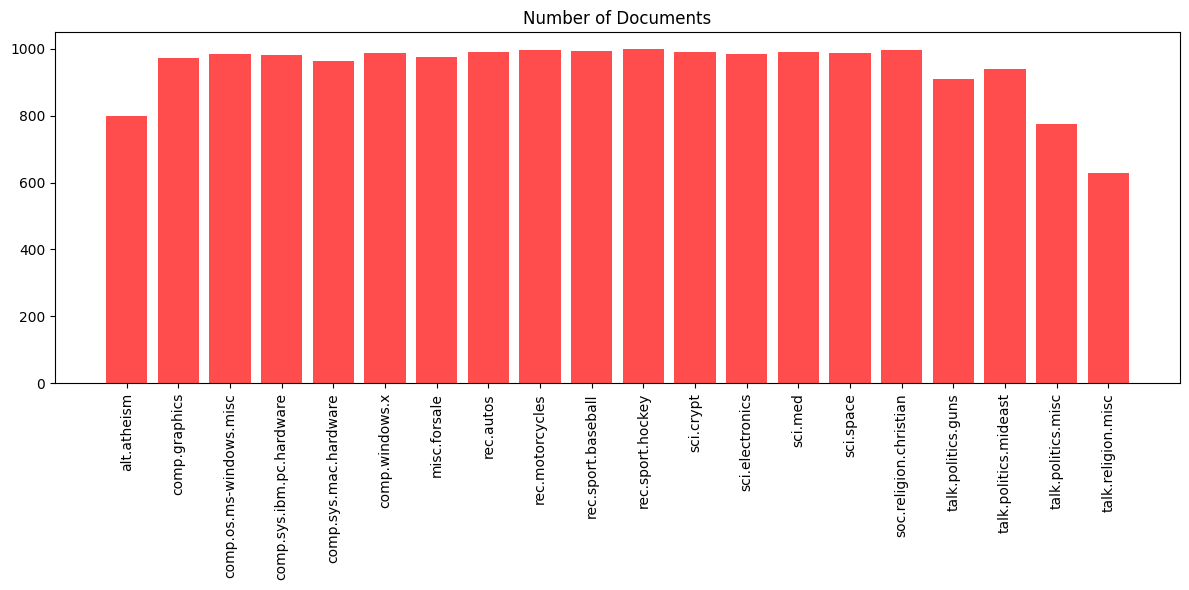

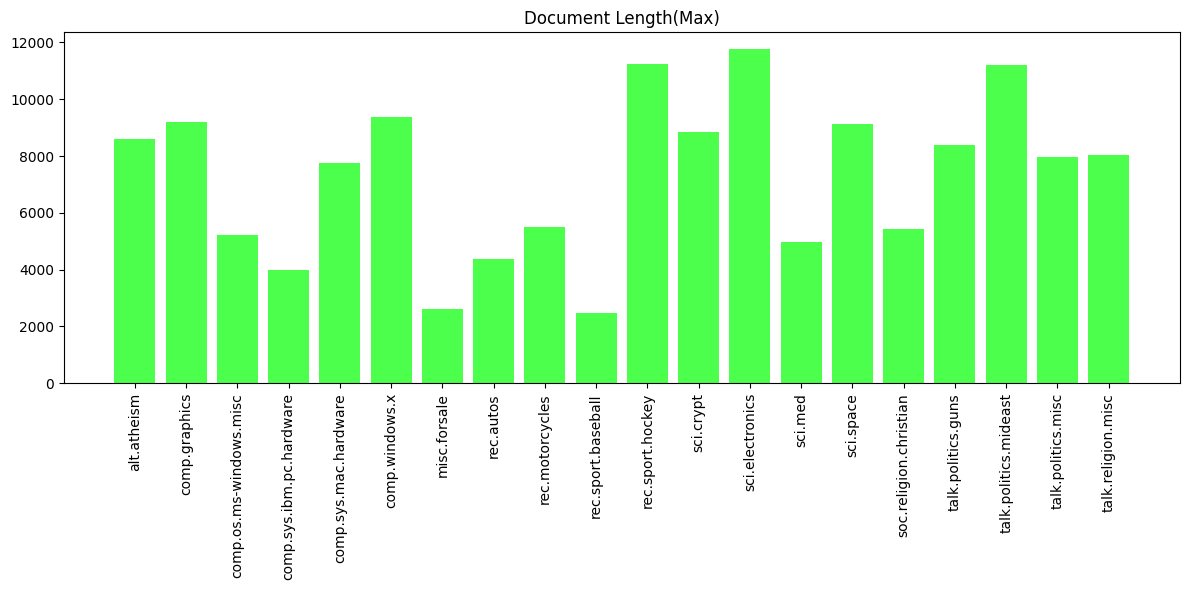

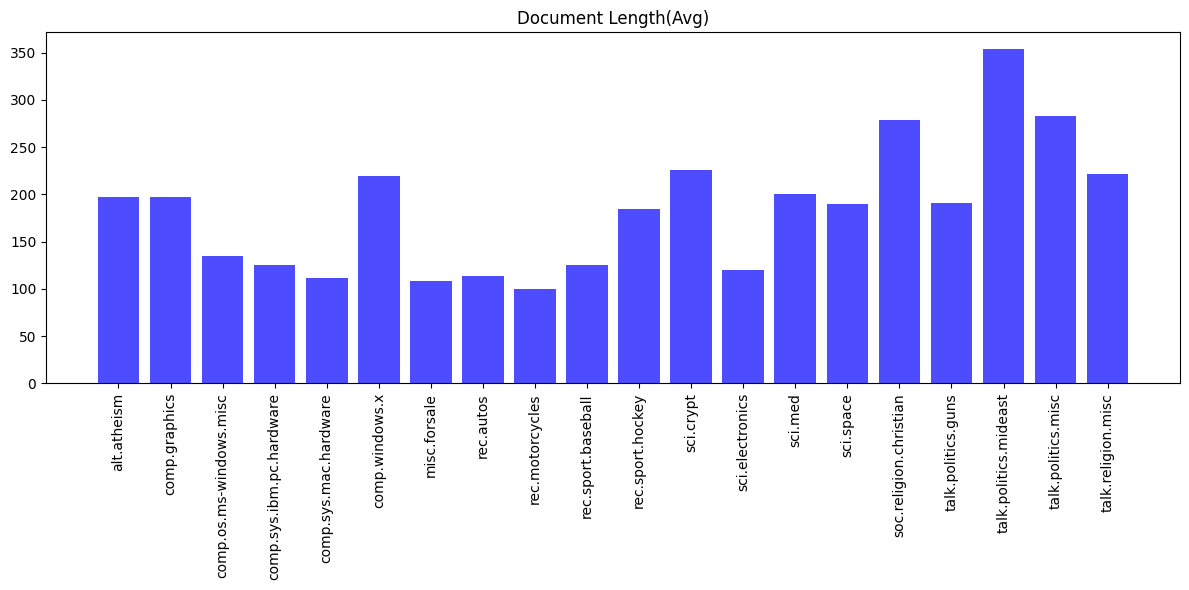

In [2]:
""" 데이터 로드 """
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = news_data.data
labels = news_data.target
categories = news_data.target_names


""" 데이터 수량 확인 """
print(f"Documents: {len(documents)}")
print(f"Labels: {len(labels)}")
print(f"Categories: {len(categories)}")
print(categories)
print(documents[0])


""" 카테고리별 데이터 수 """
category_counts_raw = Counter(labels)
category_name_counts_raw = {categories[label]: count for label, count in category_counts_raw.items()}
df_counts_raw = pd.DataFrame(list(category_name_counts_raw.items()), columns=['Category', 'Document Count'])
df_counts_raw = df_counts_raw.sort_values(by='Category').reset_index(drop=True)
total_documents = df_counts_raw['Document Count'].sum()

print(f"Total: {total_documents}")
plt.figure(figsize=(12, 6))
plt.bar(df_counts_raw['Category'], df_counts_raw['Document Count'], color=(1, 0.3, 0.3))
plt.xticks(rotation=90)
plt.title('Number of Documents')
plt.tight_layout()


""" 카테고리별 텍스트 최대 길이 """
category_max_lengths = {name: 0 for name in categories}
for i, doc in enumerate(documents):
    doc_length = len(doc.split())
    category_name = categories[labels[i]]
    if doc_length > category_max_lengths[category_name]:
        category_max_lengths[category_name] = doc_length
df_max_lengths = pd.DataFrame(list(category_max_lengths.items()), columns=['Category', 'Max Document Length'])
df_max_lengths = df_max_lengths.sort_values(by='Category').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.bar(df_max_lengths['Category'], df_max_lengths['Max Document Length'], color=(0.3, 1, 0.3))
plt.xticks(rotation=90)
plt.title('Document Length(Max)')
plt.tight_layout()


""" 카테고리별 텍스트 평균 길이 """
category_lengths = defaultdict(list)
for i, doc in enumerate(documents):
    doc_length = len(doc.split())
    category_name = categories[labels[i]]
    category_lengths[category_name].append(doc_length)
category_avg_lengths = {name: np.mean(lengths) for name, lengths in category_lengths.items()}
df_avg_lengths = pd.DataFrame(list(category_avg_lengths.items()), columns=['Category', 'Average Document Length'])
df_avg_lengths = df_avg_lengths.sort_values(by='Category').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.bar(df_avg_lengths['Category'], df_avg_lengths['Average Document Length'], color=(0.3, 0.3, 1))
plt.xticks(rotation=90)
plt.title('Document Length(Avg)')
plt.tight_layout()

# 3. 텍스트 전처리

In [3]:
""" 전처리 클래스 생성 """
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        text = text.lower()  # 소문자 변환
        text = re.sub(r'\S*@\S*\s?', '', text)  # 이메일 주소 제거
        text = re.sub(r'http\S+', '', text)  # URL 제거
        text = re.sub(r'\d+', '', text)  # 숫자 제거
        text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
        text = re.sub(r'\s+', ' ', text).strip()  # 중복&좌우 공백 제거

        if not text:
            return []

        tokens = text.split()  # 토큰화
        processed_tokens = [  # 불용어 제거 및 표제어 추출
            self.lemmatizer.lemmatize(word) for word in tokens
            if word not in self.stop_words
        ]
        return processed_tokens

    def preprocess_documents(self, documents):
        return [self.preprocess_text(doc) for doc in documents]

pp = TextPreprocessor()
processed_documents = pp.preprocess_documents(documents)

print(f"Original document example:{documents[0]}")
print(f"Processed document example:{processed_documents[0]}")

Original document example:

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


Processed document example:['sure', 'bashers', 'pen', 'fan', 'pretty', 'confused', 'lack', 'kind', 'post', 'recent', 'pen', 'massacre', 'devil', 'actually', 'bit', 'puzzled', 'bit', 'relieved', 'however', 'going', 'put', 'end', 'nonpittsburghers', 'relief', 'bi

# 4. 임베딩 모델 정의


In [4]:
""" 임베딩 모델 """
def set_embedding_models():
    # Word2Vec 모델 정의
    word2vec_model = Word2Vec(
        sentences=processed_documents,
        vector_size=200, # 100 -> 200
        window=10, # 5 -> 10
        min_count=5,
        workers=4,
        sg=1,
        epochs=20 # 10 -> 20
    )

    # FastText 모델 정의
    fasttext_model = FastText(
        sentences=processed_documents,
        vector_size=200,
        window=10,
        min_count=5,
        workers=4,
        sg=1,
        epochs=20
    )

    # GloVe 모델 정의
    download_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    glove_dir = 'news-topic-classifier/glove'
    zip_path = os.path.join(glove_dir, 'glove.6B.zip')
    glove_txt = os.path.join(glove_dir, 'glove.6B.200d.txt')
    word2vec_txt = os.path.join(glove_dir, 'glove.6B.200d.word2vec.txt')
    os.makedirs(glove_dir, exist_ok=True)

    # GloVe 다운로드
    if not os.path.exists(glove_txt):
        !wget --no-check-certificate -O news-topic-classifier/glove/glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(glove_dir)

    # 포맷 변환
    if not os.path.exists(word2vec_txt):
        glove2word2vec(glove_txt, word2vec_txt)

    # GloVe 로드
    glove_model = KeyedVectors.load_word2vec_format(word2vec_txt, binary=False)

    return word2vec_model, fasttext_model, glove_model


word2vec_model, fasttext_model, glove_model = set_embedding_models()

/tmp/ipython-input-4-1359750975.py:41: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_txt, word2vec_txt)


# 5. 데이터셋 생성

In [6]:
""" 데이터 분리 """
X_train, X_test, y_train, y_test = train_test_split(processed_documents, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Train data: {len(X_train)}")
print(f"Test data: {len(X_test)}")


""" 데이터셋 클래스 정의 """
class NewsDataset(Dataset):
    def __init__(self, documents, labels, word_to_index, max_len):
        self.documents = documents
        self.labels = labels
        self.word_to_index = word_to_index
        self.max_len = max_len

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        tokens = self.documents[idx]
        seq = [self.word_to_index.get(word, self.word_to_index['<UNK>']) for word in tokens]

        if len(seq) < self.max_len:
            seq = seq + [self.word_to_index['<PAD>']] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]

        return torch.LongTensor(seq), torch.LongTensor([self.labels[idx]])


""" 단어 사전 생성 함수 """
def create_vocabulary(train_documents):
    word_counts = Counter(word for doc in train_documents for word in doc)
    vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    word_to_index = {word: i+2 for i, word in enumerate(vocab)}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK>'] = 1
    vocab_size = len(word_to_index)
    print(f"Vocabulary size: {vocab_size}")
    return word_to_index, vocab_size

word_to_index, vocab_size = create_vocabulary(X_train)


""" 임베딩 행렬 생성 함수 """ # emb dim 100 -> 200
def create_embedding_matrix(embedding_model, word_to_index, embedding_dim=200):
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

    # 모델 종류에 따라 벡터를 담고 있는 객체를 올바르게 지정
    if isinstance(embedding_model, KeyedVectors):
        vectors = embedding_model
    else:
        vectors = embedding_model.wv

    for word, i in word_to_index.items():
        if word in vectors:
            embedding_matrix[i] = vectors[word]

    return torch.FloatTensor(embedding_matrix)

word2vec_embedding_matrix = create_embedding_matrix(word2vec_model, word_to_index)
fasttext_embedding_matrix = create_embedding_matrix(fasttext_model, word_to_index)
glove_embedding_matrix = create_embedding_matrix(glove_model, word_to_index)

# 150 -> 400
train_dataset = NewsDataset(X_train, y_train, word_to_index, max_len=400)
test_dataset = NewsDataset(X_test, y_test, word_to_index, max_len=400)

# 64 -> 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train data: 15076
Test data: 3770
Vocabulary size: 92096


# 6. 시계열 모델 정의

In [8]:
""" RNN, LSTM, GRU 모델 클래스 """
class Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, model_name=None):
        super().__init__()
        self.model_name = model_name.lower()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)

        if self.model_name == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.model_name == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.model_name == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)

        if self.model_name == 'lstm':
            hidden = hidden[0]
        if self.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            hidden = self.dropout(hidden[-1])

        return self.fc(hidden)

# 7. 모델 학습

In [12]:
""" 모델 학습 """
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model_name, emb_name, emb_matrix, train_loader, vocab_size, word_to_index, learning_rate, epochs):
    pad_idx = word_to_index['<PAD>']

    # 모델 인스턴스 생성
    model = Classifier(
        vocab_size=vocab_size,
        embedding_dim=200, # 100 -> 200
        hidden_dim=256, # 128 -> 256
        output_dim=len(set(labels)),
        n_layers=2,
        bidirectional=True,
        dropout=0.3, # 0.5 -> 0.3
        pad_idx=pad_idx,
        model_name=model_name
    ).to(device)

    # 사전 훈련된 임베딩 가중치 적용
    model.embedding.weight.data.copy_(emb_matrix)
    model.embedding.weight.data[pad_idx] = torch.zeros(200) # 100 -> 200
    model.embedding.weight.requires_grad = False

    # 옵티마이저와 손실 함수 정의
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)

    # 모델 훈련
    print(f"--- Start training [{model_name}] with [{emb_name}] ---")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_epoch = 0

        for text, label in tqdm(train_loader):
            text, label = text.to(device), label.squeeze().to(device)
            predictions = model(text)
            loss = criterion(predictions, label)

            _, predicted_labels = torch.max(predictions, 1)
            total_correct += (predicted_labels == label).sum().item()
            total_epoch += label.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_correct / total_epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f} | Train Acc: {avg_acc*100:.2f}%")

    print(f"--- Training complete for [{model_name}] with [{emb_name}] ---\n")
    return model

In [17]:
""" 파이프라인 실행 """
# 하이퍼파라미터
LEARNING_RATE = 0.0001 # 0.001 -> 0.0001
EPOCHS = 20

# 훈련된 모델 저장
trained_models = {}


""" Vanilla RNN """
trained_models['RNN_Word2Vec'] = train_model(
    model_name='RNN',
    emb_name='Word2Vec',
    emb_matrix=word2vec_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['RNN_FastText'] = train_model(
    model_name='RNN',
    emb_name='FastText',
    emb_matrix=fasttext_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['RNN_GloVe'] = train_model(
    model_name='RNN',
    emb_name='GloVe',
    emb_matrix=glove_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)


""" LSTM """
trained_models['LSTM_Word2Vec'] = train_model(
    model_name='LSTM',
    emb_name='Word2Vec',
    emb_matrix=word2vec_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['LSTM_FastText'] = train_model(
    model_name='LSTM',
    emb_name='FastText',
    emb_matrix=fasttext_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['LSTM_GloVe'] = train_model(
    model_name='LSTM',
    emb_name='GloVe',
    emb_matrix=glove_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)


""" GRU """
trained_models['GRU_Word2Vec'] = train_model(
    model_name='GRU',
    emb_name='Word2Vec',
    emb_matrix=word2vec_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['GRU_FastText'] = train_model(
    model_name='GRU',
    emb_name='FastText',
    emb_matrix=fasttext_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)
trained_models['GRU_GloVe'] = train_model(
    model_name='GRU',
    emb_name='GloVe',
    emb_matrix=glove_embedding_matrix,
    train_loader=train_loader,
    vocab_size=vocab_size,
    word_to_index=word_to_index,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS
)


print("\n===== All training processes are complete! =====")
print("Trained models are stored in the 'trained_models' dictionary.")
print(f"Stored models: {list(trained_models.keys())}")

--- Start training [RNN] with [Word2Vec] ---


100%|██████████| 472/472 [00:06<00:00, 70.88it/s]


Epoch 1/20 | Train Loss: 2.560927 | Train Acc: 16.20%


100%|██████████| 472/472 [00:06<00:00, 71.23it/s]


Epoch 2/20 | Train Loss: 1.956094 | Train Acc: 33.21%


100%|██████████| 472/472 [00:06<00:00, 71.79it/s]


Epoch 3/20 | Train Loss: 1.745898 | Train Acc: 41.11%


100%|██████████| 472/472 [00:06<00:00, 70.50it/s]


Epoch 4/20 | Train Loss: 1.597488 | Train Acc: 46.78%


100%|██████████| 472/472 [00:06<00:00, 70.92it/s]


Epoch 5/20 | Train Loss: 1.504938 | Train Acc: 49.92%


100%|██████████| 472/472 [00:06<00:00, 70.87it/s]


Epoch 6/20 | Train Loss: 1.466805 | Train Acc: 51.51%


100%|██████████| 472/472 [00:06<00:00, 71.27it/s]


Epoch 7/20 | Train Loss: 1.414580 | Train Acc: 53.86%


100%|██████████| 472/472 [00:06<00:00, 70.98it/s]


Epoch 8/20 | Train Loss: 1.397738 | Train Acc: 54.89%


100%|██████████| 472/472 [00:06<00:00, 71.20it/s]


Epoch 9/20 | Train Loss: 1.466359 | Train Acc: 53.62%


100%|██████████| 472/472 [00:06<00:00, 72.01it/s]


Epoch 10/20 | Train Loss: 1.383142 | Train Acc: 55.60%


100%|██████████| 472/472 [00:06<00:00, 72.25it/s]


Epoch 11/20 | Train Loss: 1.445350 | Train Acc: 55.23%


100%|██████████| 472/472 [00:06<00:00, 72.03it/s]


Epoch 12/20 | Train Loss: 1.344224 | Train Acc: 57.24%


100%|██████████| 472/472 [00:06<00:00, 72.12it/s]


Epoch 13/20 | Train Loss: 1.328609 | Train Acc: 57.92%


100%|██████████| 472/472 [00:06<00:00, 72.11it/s]


Epoch 14/20 | Train Loss: 1.283441 | Train Acc: 59.70%


100%|██████████| 472/472 [00:06<00:00, 72.26it/s]


Epoch 15/20 | Train Loss: 1.256896 | Train Acc: 60.13%


100%|██████████| 472/472 [00:06<00:00, 72.07it/s]


Epoch 16/20 | Train Loss: 1.354269 | Train Acc: 57.79%


100%|██████████| 472/472 [00:06<00:00, 72.26it/s]


Epoch 17/20 | Train Loss: 1.293116 | Train Acc: 59.47%


100%|██████████| 472/472 [00:06<00:00, 72.00it/s]


Epoch 18/20 | Train Loss: 1.287221 | Train Acc: 59.45%


100%|██████████| 472/472 [00:06<00:00, 71.78it/s]


Epoch 19/20 | Train Loss: 1.246251 | Train Acc: 61.36%


100%|██████████| 472/472 [00:06<00:00, 72.56it/s]


Epoch 20/20 | Train Loss: 1.481359 | Train Acc: 54.68%
--- Training complete for [RNN] with [Word2Vec] ---

--- Start training [RNN] with [FastText] ---


100%|██████████| 472/472 [00:06<00:00, 71.89it/s]


Epoch 1/20 | Train Loss: 2.519580 | Train Acc: 16.81%


100%|██████████| 472/472 [00:06<00:00, 72.59it/s]


Epoch 2/20 | Train Loss: 2.046905 | Train Acc: 29.45%


100%|██████████| 472/472 [00:06<00:00, 72.18it/s]


Epoch 3/20 | Train Loss: 2.035311 | Train Acc: 32.63%


100%|██████████| 472/472 [00:06<00:00, 72.34it/s]


Epoch 4/20 | Train Loss: 1.825623 | Train Acc: 39.03%


100%|██████████| 472/472 [00:06<00:00, 72.18it/s]


Epoch 5/20 | Train Loss: 1.680858 | Train Acc: 42.86%


100%|██████████| 472/472 [00:06<00:00, 72.61it/s]


Epoch 6/20 | Train Loss: 1.565849 | Train Acc: 46.57%


100%|██████████| 472/472 [00:06<00:00, 71.97it/s]


Epoch 7/20 | Train Loss: 1.517462 | Train Acc: 48.28%


100%|██████████| 472/472 [00:06<00:00, 72.23it/s]


Epoch 8/20 | Train Loss: 1.454406 | Train Acc: 50.63%


100%|██████████| 472/472 [00:06<00:00, 72.49it/s]


Epoch 9/20 | Train Loss: 1.610289 | Train Acc: 48.02%


100%|██████████| 472/472 [00:06<00:00, 72.61it/s]


Epoch 10/20 | Train Loss: 1.485696 | Train Acc: 50.97%


100%|██████████| 472/472 [00:06<00:00, 72.84it/s]


Epoch 11/20 | Train Loss: 1.411206 | Train Acc: 53.57%


100%|██████████| 472/472 [00:06<00:00, 72.67it/s]


Epoch 12/20 | Train Loss: 1.356218 | Train Acc: 55.04%


100%|██████████| 472/472 [00:06<00:00, 72.66it/s]


Epoch 13/20 | Train Loss: 1.336399 | Train Acc: 57.20%


100%|██████████| 472/472 [00:06<00:00, 72.76it/s]


Epoch 14/20 | Train Loss: 1.381899 | Train Acc: 55.07%


100%|██████████| 472/472 [00:06<00:00, 73.11it/s]


Epoch 15/20 | Train Loss: 1.332633 | Train Acc: 57.22%


100%|██████████| 472/472 [00:06<00:00, 72.68it/s]


Epoch 16/20 | Train Loss: 1.281407 | Train Acc: 59.00%


100%|██████████| 472/472 [00:06<00:00, 72.96it/s]


Epoch 17/20 | Train Loss: 1.280552 | Train Acc: 59.00%


100%|██████████| 472/472 [00:06<00:00, 72.84it/s]


Epoch 18/20 | Train Loss: 1.281572 | Train Acc: 59.09%


100%|██████████| 472/472 [00:06<00:00, 73.01it/s]


Epoch 19/20 | Train Loss: 1.430399 | Train Acc: 55.29%


100%|██████████| 472/472 [00:06<00:00, 72.59it/s]


Epoch 20/20 | Train Loss: 1.319715 | Train Acc: 58.29%
--- Training complete for [RNN] with [FastText] ---

--- Start training [RNN] with [GloVe] ---


100%|██████████| 472/472 [00:06<00:00, 73.01it/s]


Epoch 1/20 | Train Loss: 2.678568 | Train Acc: 13.80%


100%|██████████| 472/472 [00:06<00:00, 72.74it/s]


Epoch 2/20 | Train Loss: 2.301082 | Train Acc: 23.57%


100%|██████████| 472/472 [00:06<00:00, 72.75it/s]


Epoch 3/20 | Train Loss: 2.163209 | Train Acc: 27.57%


100%|██████████| 472/472 [00:06<00:00, 72.72it/s]


Epoch 4/20 | Train Loss: 2.037840 | Train Acc: 31.34%


100%|██████████| 472/472 [00:06<00:00, 72.63it/s]


Epoch 5/20 | Train Loss: 1.974663 | Train Acc: 34.20%


100%|██████████| 472/472 [00:06<00:00, 72.85it/s]


Epoch 6/20 | Train Loss: 1.872424 | Train Acc: 37.43%


100%|██████████| 472/472 [00:06<00:00, 72.73it/s]


Epoch 7/20 | Train Loss: 1.826937 | Train Acc: 39.30%


100%|██████████| 472/472 [00:06<00:00, 72.98it/s]


Epoch 8/20 | Train Loss: 1.820798 | Train Acc: 39.55%


100%|██████████| 472/472 [00:06<00:00, 72.86it/s]


Epoch 9/20 | Train Loss: 1.846605 | Train Acc: 39.19%


100%|██████████| 472/472 [00:06<00:00, 72.80it/s]


Epoch 10/20 | Train Loss: 1.835649 | Train Acc: 40.14%


100%|██████████| 472/472 [00:06<00:00, 72.22it/s]


Epoch 11/20 | Train Loss: 1.807257 | Train Acc: 41.02%


100%|██████████| 472/472 [00:06<00:00, 72.82it/s]


Epoch 12/20 | Train Loss: 1.755145 | Train Acc: 42.48%


100%|██████████| 472/472 [00:06<00:00, 72.60it/s]


Epoch 13/20 | Train Loss: 1.702484 | Train Acc: 43.72%


100%|██████████| 472/472 [00:06<00:00, 72.73it/s]


Epoch 14/20 | Train Loss: 1.623720 | Train Acc: 46.37%


100%|██████████| 472/472 [00:06<00:00, 72.66it/s]


Epoch 15/20 | Train Loss: 1.634968 | Train Acc: 46.33%


100%|██████████| 472/472 [00:06<00:00, 72.45it/s]


Epoch 16/20 | Train Loss: 1.576342 | Train Acc: 47.91%


100%|██████████| 472/472 [00:06<00:00, 73.11it/s]


Epoch 17/20 | Train Loss: 1.557576 | Train Acc: 48.24%


100%|██████████| 472/472 [00:06<00:00, 72.66it/s]


Epoch 18/20 | Train Loss: 1.549197 | Train Acc: 48.47%


100%|██████████| 472/472 [00:06<00:00, 73.14it/s]


Epoch 19/20 | Train Loss: 1.543056 | Train Acc: 49.25%


100%|██████████| 472/472 [00:06<00:00, 72.94it/s]


Epoch 20/20 | Train Loss: 1.752547 | Train Acc: 43.71%
--- Training complete for [RNN] with [GloVe] ---

--- Start training [LSTM] with [Word2Vec] ---


100%|██████████| 472/472 [00:21<00:00, 21.58it/s]


Epoch 1/20 | Train Loss: 2.524910 | Train Acc: 17.69%


100%|██████████| 472/472 [00:21<00:00, 21.58it/s]


Epoch 2/20 | Train Loss: 1.850893 | Train Acc: 37.30%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 3/20 | Train Loss: 1.576103 | Train Acc: 47.15%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 4/20 | Train Loss: 1.413995 | Train Acc: 52.61%


100%|██████████| 472/472 [00:22<00:00, 21.42it/s]


Epoch 5/20 | Train Loss: 1.326803 | Train Acc: 56.37%


100%|██████████| 472/472 [00:21<00:00, 21.59it/s]


Epoch 6/20 | Train Loss: 1.245488 | Train Acc: 58.98%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 7/20 | Train Loss: 1.208662 | Train Acc: 60.59%


100%|██████████| 472/472 [00:21<00:00, 21.55it/s]


Epoch 8/20 | Train Loss: 1.170566 | Train Acc: 62.21%


100%|██████████| 472/472 [00:21<00:00, 21.53it/s]


Epoch 9/20 | Train Loss: 1.119337 | Train Acc: 64.31%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 10/20 | Train Loss: 1.108051 | Train Acc: 64.79%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 11/20 | Train Loss: 1.061695 | Train Acc: 66.26%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 12/20 | Train Loss: 1.045241 | Train Acc: 66.93%


100%|██████████| 472/472 [00:21<00:00, 21.54it/s]


Epoch 13/20 | Train Loss: 1.032565 | Train Acc: 67.39%


100%|██████████| 472/472 [00:21<00:00, 21.61it/s]


Epoch 14/20 | Train Loss: 0.995790 | Train Acc: 68.57%


100%|██████████| 472/472 [00:21<00:00, 21.46it/s]


Epoch 15/20 | Train Loss: 0.977125 | Train Acc: 69.00%


100%|██████████| 472/472 [00:22<00:00, 21.38it/s]


Epoch 16/20 | Train Loss: 0.950143 | Train Acc: 70.08%


100%|██████████| 472/472 [00:22<00:00, 21.02it/s]


Epoch 17/20 | Train Loss: 0.948329 | Train Acc: 70.06%


100%|██████████| 472/472 [00:22<00:00, 21.28it/s]


Epoch 18/20 | Train Loss: 0.920437 | Train Acc: 71.09%


100%|██████████| 472/472 [00:22<00:00, 21.40it/s]


Epoch 19/20 | Train Loss: 0.917227 | Train Acc: 70.88%


100%|██████████| 472/472 [00:22<00:00, 21.29it/s]


Epoch 20/20 | Train Loss: 0.893365 | Train Acc: 71.92%
--- Training complete for [LSTM] with [Word2Vec] ---

--- Start training [LSTM] with [FastText] ---


100%|██████████| 472/472 [00:22<00:00, 20.99it/s]


Epoch 1/20 | Train Loss: 2.477367 | Train Acc: 18.14%


100%|██████████| 472/472 [00:22<00:00, 20.99it/s]


Epoch 2/20 | Train Loss: 1.875654 | Train Acc: 34.08%


100%|██████████| 472/472 [00:22<00:00, 21.02it/s]


Epoch 3/20 | Train Loss: 1.626762 | Train Acc: 44.36%


100%|██████████| 472/472 [00:22<00:00, 21.08it/s]


Epoch 4/20 | Train Loss: 1.473609 | Train Acc: 50.72%


100%|██████████| 472/472 [00:22<00:00, 21.34it/s]


Epoch 5/20 | Train Loss: 1.354979 | Train Acc: 54.66%


100%|██████████| 472/472 [00:22<00:00, 21.21it/s]


Epoch 6/20 | Train Loss: 1.293616 | Train Acc: 57.44%


100%|██████████| 472/472 [00:22<00:00, 20.90it/s]


Epoch 7/20 | Train Loss: 1.220829 | Train Acc: 60.02%


100%|██████████| 472/472 [00:22<00:00, 20.88it/s]


Epoch 8/20 | Train Loss: 1.176384 | Train Acc: 61.46%


100%|██████████| 472/472 [00:22<00:00, 21.09it/s]


Epoch 9/20 | Train Loss: 1.145345 | Train Acc: 62.85%


100%|██████████| 472/472 [00:22<00:00, 21.28it/s]


Epoch 10/20 | Train Loss: 1.100596 | Train Acc: 64.40%


100%|██████████| 472/472 [00:22<00:00, 21.34it/s]


Epoch 11/20 | Train Loss: 1.076782 | Train Acc: 65.40%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 12/20 | Train Loss: 1.038789 | Train Acc: 67.35%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 13/20 | Train Loss: 1.008121 | Train Acc: 68.27%


100%|██████████| 472/472 [00:22<00:00, 21.42it/s]


Epoch 14/20 | Train Loss: 0.998893 | Train Acc: 68.19%


100%|██████████| 472/472 [00:22<00:00, 21.45it/s]


Epoch 15/20 | Train Loss: 0.979625 | Train Acc: 69.28%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 16/20 | Train Loss: 0.948868 | Train Acc: 69.90%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 17/20 | Train Loss: 0.935077 | Train Acc: 70.64%


100%|██████████| 472/472 [00:21<00:00, 21.49it/s]


Epoch 18/20 | Train Loss: 0.924705 | Train Acc: 70.78%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 19/20 | Train Loss: 0.909179 | Train Acc: 71.55%


100%|██████████| 472/472 [00:21<00:00, 21.53it/s]


Epoch 20/20 | Train Loss: 0.896535 | Train Acc: 71.76%
--- Training complete for [LSTM] with [FastText] ---

--- Start training [LSTM] with [GloVe] ---


100%|██████████| 472/472 [00:22<00:00, 21.41it/s]


Epoch 1/20 | Train Loss: 2.573176 | Train Acc: 16.08%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 2/20 | Train Loss: 2.039827 | Train Acc: 29.48%


100%|██████████| 472/472 [00:21<00:00, 21.51it/s]


Epoch 3/20 | Train Loss: 1.826237 | Train Acc: 38.58%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 4/20 | Train Loss: 1.651493 | Train Acc: 45.20%


100%|██████████| 472/472 [00:21<00:00, 21.61it/s]


Epoch 5/20 | Train Loss: 1.559700 | Train Acc: 47.83%


100%|██████████| 472/472 [00:22<00:00, 21.25it/s]


Epoch 6/20 | Train Loss: 1.477641 | Train Acc: 50.54%


100%|██████████| 472/472 [00:22<00:00, 21.09it/s]


Epoch 7/20 | Train Loss: 1.433700 | Train Acc: 52.37%


100%|██████████| 472/472 [00:22<00:00, 21.42it/s]


Epoch 8/20 | Train Loss: 1.392816 | Train Acc: 53.17%


100%|██████████| 472/472 [00:22<00:00, 21.45it/s]


Epoch 9/20 | Train Loss: 1.365066 | Train Acc: 54.66%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 10/20 | Train Loss: 1.344101 | Train Acc: 55.23%


100%|██████████| 472/472 [00:21<00:00, 21.51it/s]


Epoch 11/20 | Train Loss: 1.313228 | Train Acc: 56.34%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 12/20 | Train Loss: 1.286893 | Train Acc: 57.58%


100%|██████████| 472/472 [00:21<00:00, 21.61it/s]


Epoch 13/20 | Train Loss: 1.255223 | Train Acc: 58.44%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 14/20 | Train Loss: 1.238215 | Train Acc: 58.85%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 15/20 | Train Loss: 1.224820 | Train Acc: 59.68%


100%|██████████| 472/472 [00:21<00:00, 21.54it/s]


Epoch 16/20 | Train Loss: 1.196976 | Train Acc: 60.53%


100%|██████████| 472/472 [00:22<00:00, 21.39it/s]


Epoch 17/20 | Train Loss: 1.169232 | Train Acc: 61.46%


100%|██████████| 472/472 [00:22<00:00, 21.44it/s]


Epoch 18/20 | Train Loss: 1.164953 | Train Acc: 61.66%


100%|██████████| 472/472 [00:22<00:00, 21.44it/s]


Epoch 19/20 | Train Loss: 1.165518 | Train Acc: 61.63%


100%|██████████| 472/472 [00:22<00:00, 21.41it/s]


Epoch 20/20 | Train Loss: 1.122928 | Train Acc: 62.95%
--- Training complete for [LSTM] with [GloVe] ---

--- Start training [GRU] with [Word2Vec] ---


100%|██████████| 472/472 [00:22<00:00, 21.44it/s]


Epoch 1/20 | Train Loss: 2.419156 | Train Acc: 20.93%


100%|██████████| 472/472 [00:22<00:00, 21.37it/s]


Epoch 2/20 | Train Loss: 1.791271 | Train Acc: 37.43%


100%|██████████| 472/472 [00:22<00:00, 21.35it/s]


Epoch 3/20 | Train Loss: 1.538590 | Train Acc: 47.78%


100%|██████████| 472/472 [00:22<00:00, 21.37it/s]


Epoch 4/20 | Train Loss: 1.342770 | Train Acc: 55.14%


100%|██████████| 472/472 [00:21<00:00, 21.61it/s]


Epoch 5/20 | Train Loss: 1.219991 | Train Acc: 59.63%


100%|██████████| 472/472 [00:21<00:00, 21.56it/s]


Epoch 6/20 | Train Loss: 1.138239 | Train Acc: 62.91%


100%|██████████| 472/472 [00:21<00:00, 21.52it/s]


Epoch 7/20 | Train Loss: 1.095182 | Train Acc: 64.47%


100%|██████████| 472/472 [00:21<00:00, 21.58it/s]


Epoch 8/20 | Train Loss: 1.049863 | Train Acc: 66.51%


100%|██████████| 472/472 [00:21<00:00, 21.51it/s]


Epoch 9/20 | Train Loss: 1.011545 | Train Acc: 67.46%


100%|██████████| 472/472 [00:21<00:00, 21.60it/s]


Epoch 10/20 | Train Loss: 0.987444 | Train Acc: 68.29%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 11/20 | Train Loss: 0.958141 | Train Acc: 69.85%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 12/20 | Train Loss: 0.930015 | Train Acc: 70.28%


100%|██████████| 472/472 [00:21<00:00, 21.65it/s]


Epoch 13/20 | Train Loss: 0.914964 | Train Acc: 71.27%


100%|██████████| 472/472 [00:21<00:00, 21.60it/s]


Epoch 14/20 | Train Loss: 0.891020 | Train Acc: 71.50%


100%|██████████| 472/472 [00:21<00:00, 21.70it/s]


Epoch 15/20 | Train Loss: 0.864470 | Train Acc: 72.72%


100%|██████████| 472/472 [00:21<00:00, 21.64it/s]


Epoch 16/20 | Train Loss: 0.858467 | Train Acc: 72.47%


100%|██████████| 472/472 [00:21<00:00, 21.55it/s]


Epoch 17/20 | Train Loss: 0.837857 | Train Acc: 73.28%


100%|██████████| 472/472 [00:21<00:00, 21.63it/s]


Epoch 18/20 | Train Loss: 0.824627 | Train Acc: 73.89%


100%|██████████| 472/472 [00:21<00:00, 21.67it/s]


Epoch 19/20 | Train Loss: 0.814474 | Train Acc: 73.92%


100%|██████████| 472/472 [00:21<00:00, 21.68it/s]


Epoch 20/20 | Train Loss: 0.799130 | Train Acc: 74.46%
--- Training complete for [GRU] with [Word2Vec] ---

--- Start training [GRU] with [FastText] ---


100%|██████████| 472/472 [00:21<00:00, 21.46it/s]


Epoch 1/20 | Train Loss: 2.464609 | Train Acc: 19.24%


100%|██████████| 472/472 [00:21<00:00, 21.58it/s]


Epoch 2/20 | Train Loss: 1.765802 | Train Acc: 38.82%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 3/20 | Train Loss: 1.452395 | Train Acc: 51.18%


100%|██████████| 472/472 [00:21<00:00, 21.69it/s]


Epoch 4/20 | Train Loss: 1.293324 | Train Acc: 56.41%


100%|██████████| 472/472 [00:21<00:00, 21.66it/s]


Epoch 5/20 | Train Loss: 1.207757 | Train Acc: 59.76%


100%|██████████| 472/472 [00:21<00:00, 21.69it/s]


Epoch 6/20 | Train Loss: 1.142230 | Train Acc: 61.95%


100%|██████████| 472/472 [00:21<00:00, 21.68it/s]


Epoch 7/20 | Train Loss: 1.090534 | Train Acc: 64.30%


100%|██████████| 472/472 [00:21<00:00, 21.62it/s]


Epoch 8/20 | Train Loss: 1.056517 | Train Acc: 65.81%


100%|██████████| 472/472 [00:21<00:00, 21.64it/s]


Epoch 9/20 | Train Loss: 1.019626 | Train Acc: 66.90%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 10/20 | Train Loss: 0.991297 | Train Acc: 67.99%


100%|██████████| 472/472 [00:21<00:00, 21.63it/s]


Epoch 11/20 | Train Loss: 0.959596 | Train Acc: 69.49%


100%|██████████| 472/472 [00:21<00:00, 21.53it/s]


Epoch 12/20 | Train Loss: 0.929716 | Train Acc: 70.70%


100%|██████████| 472/472 [00:21<00:00, 21.65it/s]


Epoch 13/20 | Train Loss: 0.906553 | Train Acc: 71.19%


100%|██████████| 472/472 [00:22<00:00, 21.15it/s]


Epoch 14/20 | Train Loss: 0.877878 | Train Acc: 71.89%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 15/20 | Train Loss: 0.870013 | Train Acc: 72.11%


100%|██████████| 472/472 [00:21<00:00, 21.66it/s]


Epoch 16/20 | Train Loss: 0.852786 | Train Acc: 72.96%


100%|██████████| 472/472 [00:21<00:00, 21.60it/s]


Epoch 17/20 | Train Loss: 0.835382 | Train Acc: 73.42%


100%|██████████| 472/472 [00:22<00:00, 21.43it/s]


Epoch 18/20 | Train Loss: 0.823311 | Train Acc: 73.76%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 19/20 | Train Loss: 0.804435 | Train Acc: 74.33%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 20/20 | Train Loss: 0.796476 | Train Acc: 74.78%
--- Training complete for [GRU] with [FastText] ---

--- Start training [GRU] with [GloVe] ---


100%|██████████| 472/472 [00:21<00:00, 21.63it/s]


Epoch 1/20 | Train Loss: 2.549338 | Train Acc: 16.54%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 2/20 | Train Loss: 1.971482 | Train Acc: 32.77%


100%|██████████| 472/472 [00:21<00:00, 21.48it/s]


Epoch 3/20 | Train Loss: 1.700757 | Train Acc: 41.64%


100%|██████████| 472/472 [00:21<00:00, 21.55it/s]


Epoch 4/20 | Train Loss: 1.552253 | Train Acc: 46.96%


100%|██████████| 472/472 [00:21<00:00, 21.50it/s]


Epoch 5/20 | Train Loss: 1.465315 | Train Acc: 50.54%


100%|██████████| 472/472 [00:21<00:00, 21.58it/s]


Epoch 6/20 | Train Loss: 1.393018 | Train Acc: 53.08%


100%|██████████| 472/472 [00:22<00:00, 21.28it/s]


Epoch 7/20 | Train Loss: 1.333350 | Train Acc: 54.98%


100%|██████████| 472/472 [00:21<00:00, 21.46it/s]


Epoch 8/20 | Train Loss: 1.283847 | Train Acc: 56.69%


100%|██████████| 472/472 [00:22<00:00, 21.42it/s]


Epoch 9/20 | Train Loss: 1.249377 | Train Acc: 58.12%


100%|██████████| 472/472 [00:21<00:00, 21.55it/s]


Epoch 10/20 | Train Loss: 1.203948 | Train Acc: 59.90%


100%|██████████| 472/472 [00:21<00:00, 21.57it/s]


Epoch 11/20 | Train Loss: 1.170811 | Train Acc: 61.01%


100%|██████████| 472/472 [00:21<00:00, 21.49it/s]


Epoch 12/20 | Train Loss: 1.142054 | Train Acc: 62.50%


100%|██████████| 472/472 [00:22<00:00, 21.34it/s]


Epoch 13/20 | Train Loss: 1.108463 | Train Acc: 63.50%


100%|██████████| 472/472 [00:21<00:00, 21.47it/s]


Epoch 14/20 | Train Loss: 1.088631 | Train Acc: 64.43%


100%|██████████| 472/472 [00:22<00:00, 21.45it/s]


Epoch 15/20 | Train Loss: 1.059481 | Train Acc: 65.38%


100%|██████████| 472/472 [00:22<00:00, 21.32it/s]


Epoch 16/20 | Train Loss: 1.032110 | Train Acc: 66.48%


100%|██████████| 472/472 [00:22<00:00, 21.36it/s]


Epoch 17/20 | Train Loss: 1.014450 | Train Acc: 67.06%


100%|██████████| 472/472 [00:21<00:00, 21.51it/s]


Epoch 18/20 | Train Loss: 0.989863 | Train Acc: 67.83%


100%|██████████| 472/472 [00:22<00:00, 21.38it/s]


Epoch 19/20 | Train Loss: 0.965788 | Train Acc: 68.73%


100%|██████████| 472/472 [00:22<00:00, 21.40it/s]

Epoch 20/20 | Train Loss: 0.948591 | Train Acc: 69.31%
--- Training complete for [GRU] with [GloVe] ---


===== All training processes are complete! =====
Trained models are stored in the 'trained_models' dictionary.
Stored models: ['RNN_Word2Vec', 'RNN_FastText', 'RNN_GloVe', 'LSTM_Word2Vec', 'LSTM_FastText', 'LSTM_GloVe', 'GRU_Word2Vec', 'GRU_FastText', 'GRU_GloVe']


# 8. 모델 평가

In [20]:
""" 모델 평가 함수 """
def evaluate_model(model, test_loader):
    # 모델을 평가 모드로 설정
    model.eval()

    criterion = nn.CrossEntropyLoss().to(device)
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    # 평가 과정에서는 gradient를 계산할 필요가 없음
    with torch.no_grad():
        for batch in tqdm(test_loader):
            text, label = batch
            text = text.to(device)
            label = label.squeeze().to(device)

            predictions = model(text)
            loss = criterion(predictions, label)

            _, predicted_labels = torch.max(predictions, 1)

            total_loss += loss.item()
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # sklearn.metrics를 사용해 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1


""" 저장된 모든 모델에 대해 평가 실행 """
results_list = []

for model_key, model in trained_models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

    # 결과 저장
    model_name, emb_name = model_key.split('_')
    results_list.append({
        'Model': model_name,
        'Embedding': emb_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })


""" 최종 결과 출력 """
results_df = pd.DataFrame(results_list)

# 보기 좋게 정렬
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("\n\n▶▶▶ 최종 모델 성능 평가표 ◀◀◀")
print(results_df)

100%|██████████| 118/118 [00:02<00:00, 49.14it/s]



▶▶▶ 최종 모델 성능 평가표 ◀◀◀
  Model Embedding  Accuracy  Precision    Recall  F1-score
0   GRU  Word2Vec  0.724138   0.731247  0.724138  0.721918
1   GRU  FastText  0.712202   0.721316  0.712202  0.710621
2  LSTM  FastText  0.706631   0.719696  0.706631  0.704244
3  LSTM  Word2Vec  0.701592   0.712441  0.701592  0.692673
4   GRU     GloVe  0.645093   0.674030  0.645093  0.645537
5   RNN  FastText  0.601857   0.620979  0.601857  0.593050
6  LSTM     GloVe  0.595756   0.608606  0.595756  0.588674
7   RNN  Word2Vec  0.524403   0.540102  0.524403  0.498131
8   RNN     GloVe  0.484615   0.507190  0.484615  0.476346
